# 02-peak-local-max.ipynb
This notebook is similar continues the segmentation procedure outline in `README.md`, with a different step for determing the local maxima. 
Steps performed here include:
- Load data
- Calculate local maxima for foreground seed
- Calculate local maxima of gradient for background seeds

Note: This NB uses `napari` as an image viewer. If you would rather not use `napari`, see NB 01 for a way to view images using `matplotlib.pyplot` instead.

# Import packages

In [1]:
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import imagecodecs  # dependency required for loading compressed tif images
import imageio as iio
import napari
import matplotlib.pyplot as plt
import numpy as np
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

# Load data

In [2]:
# open napari viewer
viewer = napari.Viewer()

In [3]:
project_dir = Path('..').resolve()
print(project_dir)

C:\Users\gusb\Research\mhe-analysis


img.shape=(1004, 924)
img.dtype=dtype('float64')


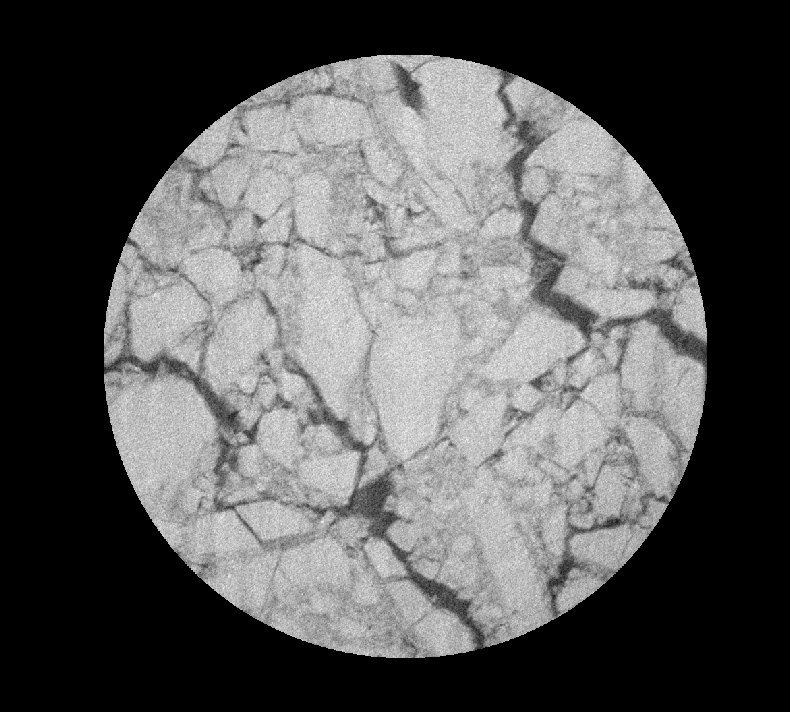

In [4]:
img_path = Path(project_dir / 'IDOX_500.tif')   
img = iio.imread(img_path)
img = util.img_as_float(img)
print(f'{img.shape=}')
print(f'{img.dtype=}')
viewer.add_image(img)
napari.utils.nbscreenshot(viewer, canvas_only=True)

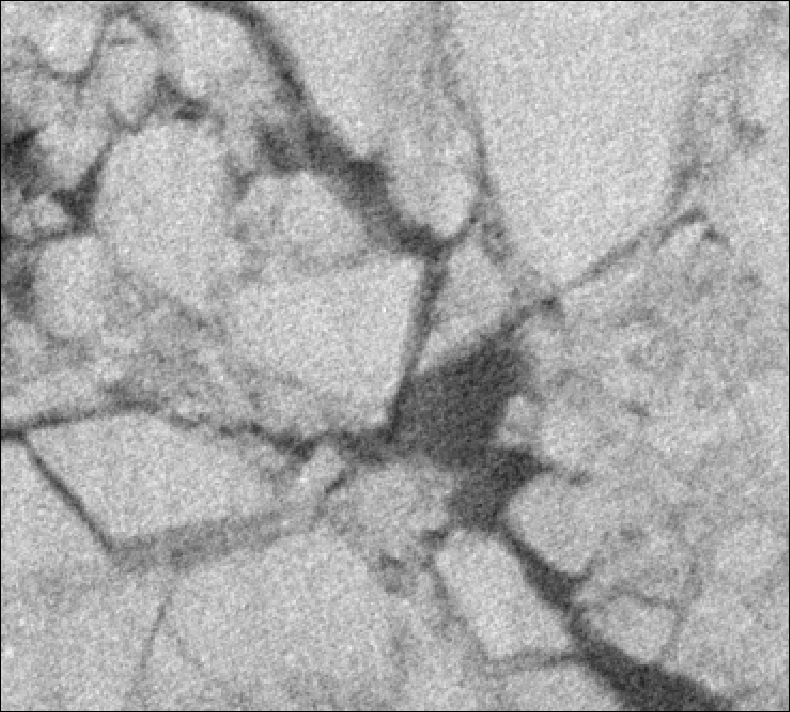

In [5]:
# Set pan and zoom of napari viewer canvas
viewer.camera.center = (0.0, 689.2612381934023, 396.8073265457061)
viewer.camera.zoom = 2.1378809891850925
napari.utils.nbscreenshot(viewer, canvas_only=True)

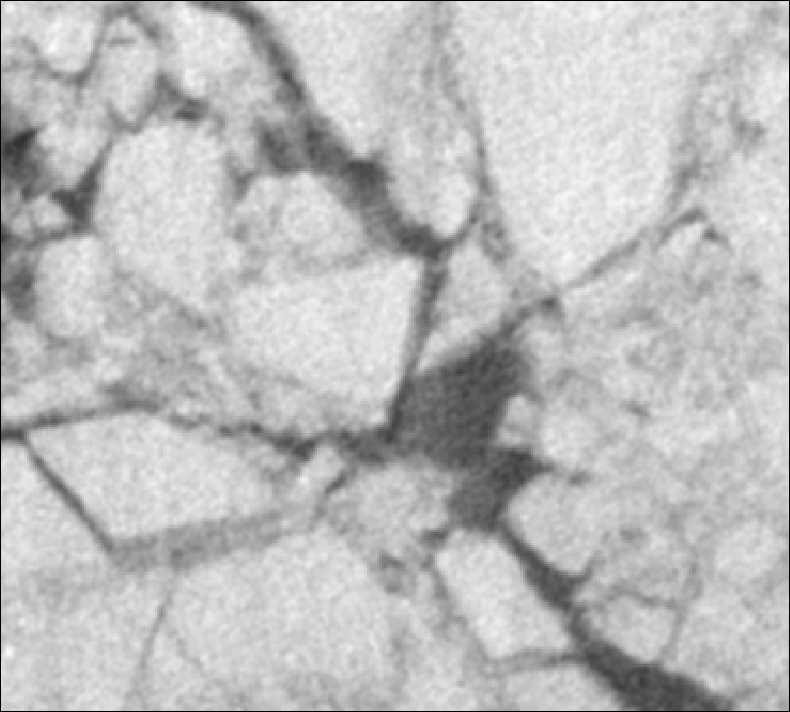

In [6]:
smooth = filters.gaussian(img)
viewer.add_image(smooth)
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Calculate local maxima for foreground seeds

For some reason it didn't show up in Google searches, but I finally found an h-maxima algorithm for determining local maxima in `skimage` within the `morphology` submodule.

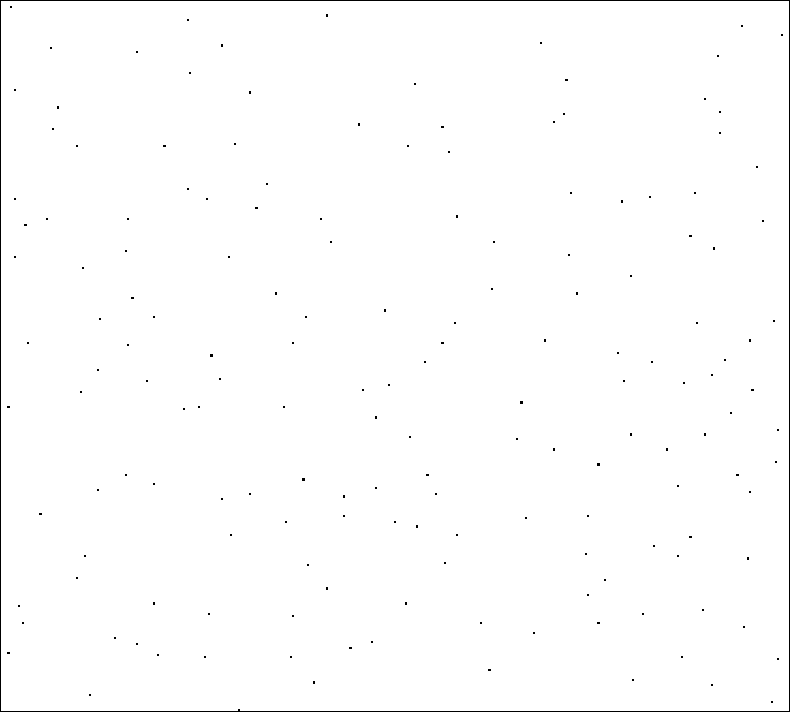

In [7]:
img = smooth.copy()
h = 0.05
h_max = morphology.h_maxima(img, h)
h_max_inv = 1 - h_max.astype(float) 
viewer.add_image(h_max_inv)
napari.utils.nbscreenshot(viewer, canvas_only=True)

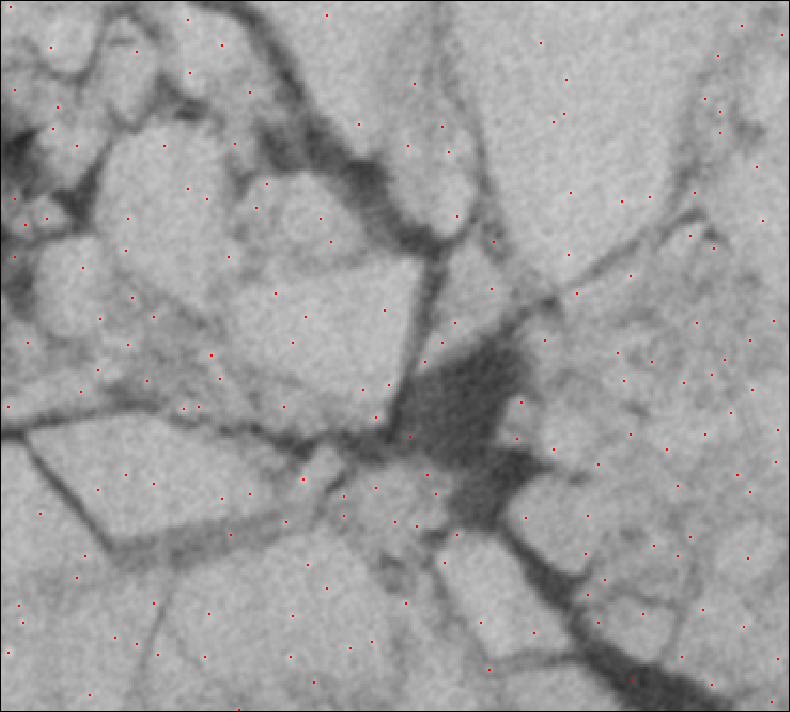

In [8]:
h_max_label = measure.label(h_max)
h_max_overlay = color.label2rgb(
    h_max_label, image=img, alpha=1, colors=[(1, 0, 0)],
    bg_label=0, bg_color=None
)
viewer.add_image(h_max_overlay, name=f'max(smooth): {h=}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

Now that we have the h-maxima values, we can select the area within h to create the foreground seeds.

We need to iterate through each of the maxima and create a flood selection for the pixels connected to the maxima that are within within the height, h. Since we ar elooking at the local maxima, the pixels will be less than or equal to those maxima. After selection, the pixels will be added to the labeled image.

In [9]:
def get_h_max_flood(img, h):
    h_max = morphology.h_maxima(img, h)
    h_max_label = measure.label(h_max)
    for region in measure.regionprops(h_max_label):
        region_coords = tuple(region.coords[0])
        flood_sel = segmentation.flood(
            img,  
            region_coords,  # Starting point for flood selection
            tolerance=h  # Select values within this tolerance connected to seed
        )
        h_max_label[np.where(flood_sel)] = region.label
    overlay = color.label2rgb(
        h_max_label, image=smooth, alpha=1, colors=[(1, 0, 0)],
        bg_label=0, bg_color=None
    )
    return h_max_label, overlay

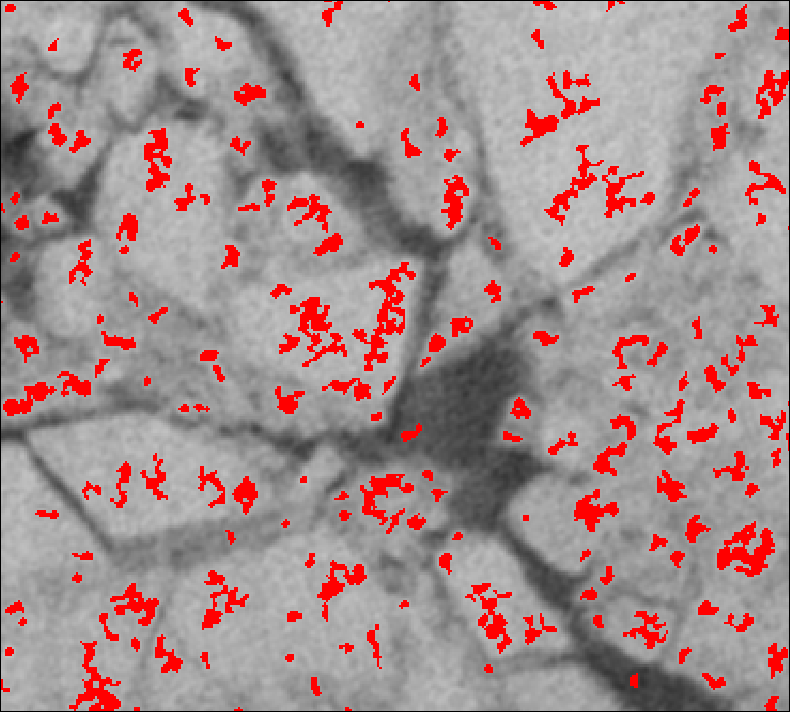

In [10]:
h_max_label, h_max_overlay = get_h_max_flood(smooth, 0.05)
viewer.add_image(h_max_overlay, name=f'filled_max')
napari.utils.nbscreenshot(viewer, canvas_only=True)

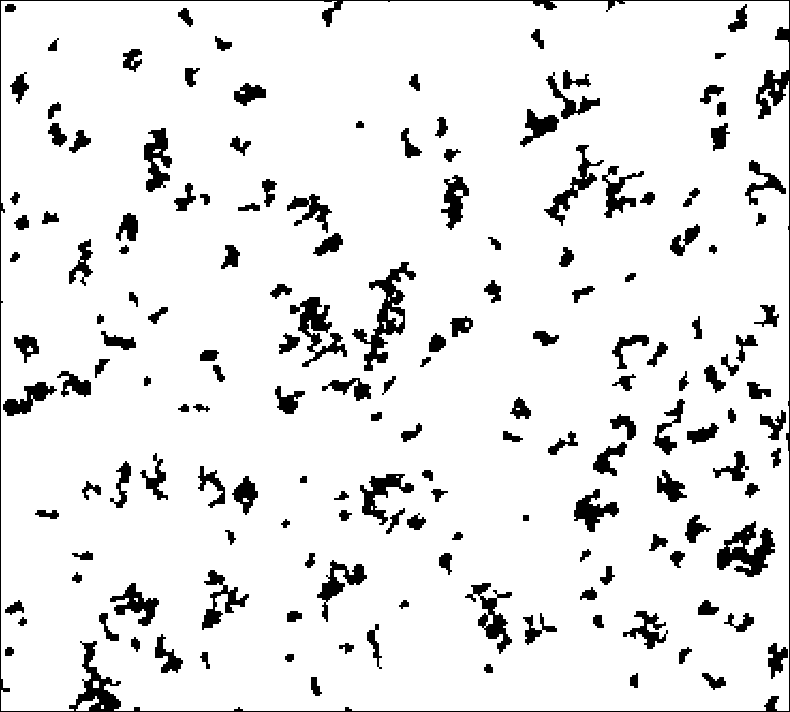

In [11]:
h_max_label_inv = np.zeros_like(h_max_label, dtype=float)
h_max_label_inv[np.nonzero(h_max_label)] = 1
h_max_label_inv = 1 - h_max_label_inv
viewer.add_image(h_max_label_inv)
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Calculate local maxima of gradient for background seeds

## Calulcate gradient of image

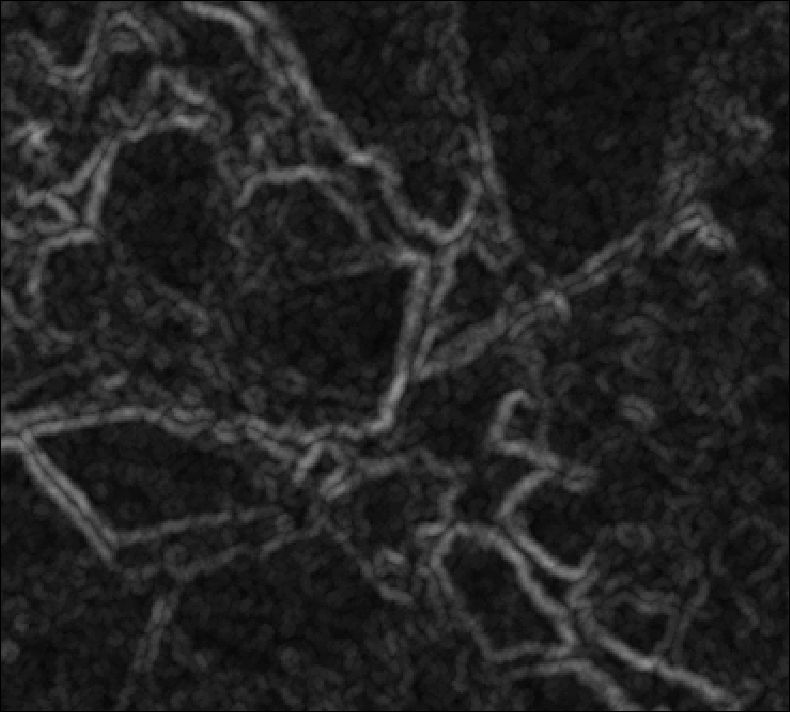

In [12]:
grad = filters.rank.gradient(util.img_as_ubyte(smooth), morphology.disk(3))
grad = util.img_as_float(grad)
viewer.add_image(grad)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Calculate h-minima of gradient

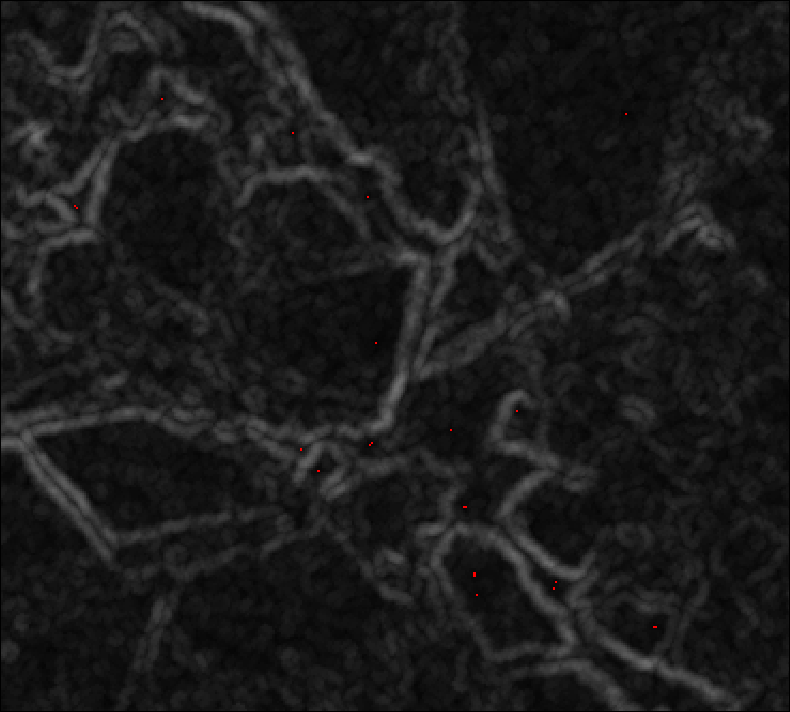

In [13]:
h = 0.09
h_min = morphology.h_minima(grad, h)
h_min_label = measure.label(h_min)
h_min_grad_overlay = color.label2rgb(
    h_min_label, image=grad, alpha=1, colors=[(1, 0, 0)],
    bg_label=0, bg_color=None
)
viewer.add_image(h_min_grad_overlay, name=f'min(grad): {h=}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

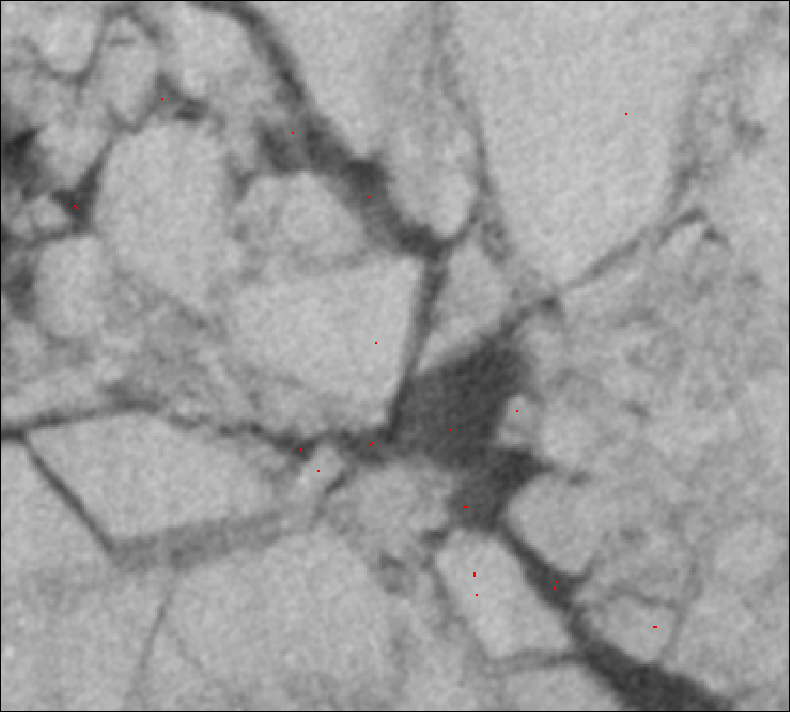

In [14]:
h_min_smooth_overlay = color.label2rgb(
    h_min_label, image=smooth, alpha=1, colors=[(1, 0, 0)],
    bg_label=0, bg_color=None
)
viewer.add_image(h_min_smooth_overlay, name=f'min(grad): {h=}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

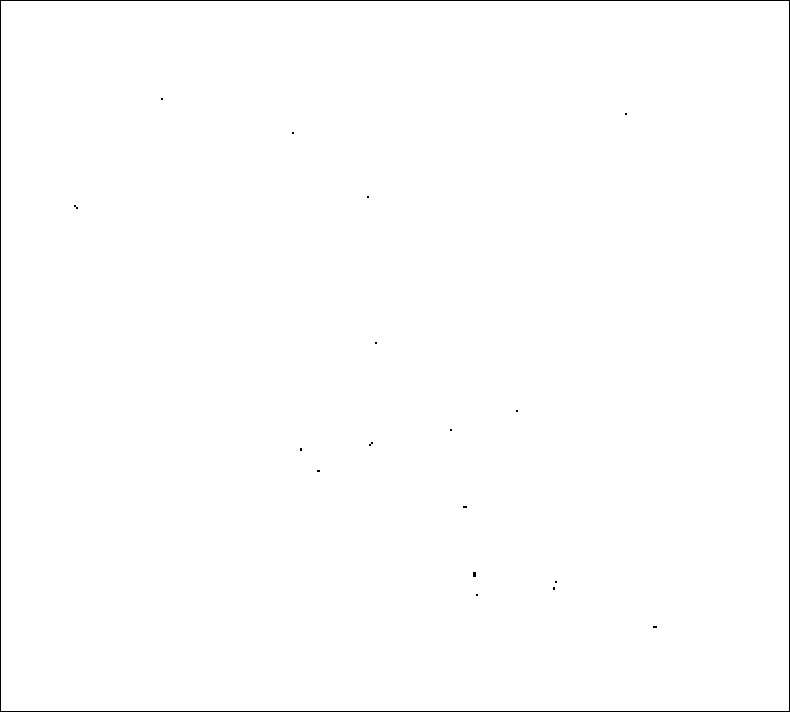

In [15]:
h_min_label_inv = np.zeros_like(h_min_label, dtype=float)
h_min_label_inv[np.nonzero(h_min_label)] = 1
h_min_label_inv = 1 - h_min_label_inv
viewer.add_image(h_min_label_inv)
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [ ]:
regions = measure.regionprops(h_min_label)
sorted(regions, key=lambda region: region.label)
for region in regions:
    print(region.label)
    region_coords = tuple(region.coords[0])
    flood_sel = segmentation.flood(
        grad,  
        region_coords,  # Starting point for flood selection
        tolerance=h  # Select values within this tolerance connected to seed
    )
    h_min_label[np.where(flood_sel)] = region.label
h_min_flood_grad_overlay = color.label2rgb(
    h_min_label, image=grad, alpha=1, colors=[(1, 0, 0)],
    bg_label=0, bg_color=None
)
viewer.add_image(h_min_flood_grad_overlay, name=f'min(grad): {h=}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

Trying to find a work-around for a proof of concept since the above cell is not running without an error.

In [ ]:
h_max = morphology.h_maxima(img, h)
h_max_label = measure.label(h_max)
regions = measure.regionprops(h_max_label)
tuple(regions[0].coords[0])

In [ ]:
h_min = morphology.h_minima(grad, h)
h_min_label = measure.label(h_min)
# h_min_label[569, 288]
regions = measure.regionprops(h_min_label)
# regions[40].label
print(regions[9].coords)

In [ ]:
# Set pan and zoom of napari viewer canvas
viewer.camera.center = (0.0, 689.2612381934023, 396.8073265457061)
viewer.camera.zoom = 2.1378809891850925

In [ ]:
for r, c in [
    (569, 288),
    (619, 247),
    (620, 248),
    (585, 349),
    (615, 384),
    (683, 388),
    (733, 353),
    (743, 361),
    (724, 423)
]:
    print(h_min_label[r, c])

In [ ]:
regions = measure.regionprops(h_min_label)
sorted(regions, key=lambda region: region.label)
for region in regions:
    if region.label in [41, 47, 43, 46, 52, 62, 63, 57]:
        region_coords = tuple(region.coords[0])
        flood_sel = segmentation.flood(
            grad,  
            region_coords,  # Starting point for flood selection
            tolerance=h  # Select values within this tolerance connected to seed
        )
        h_min_label[np.where(flood_sel)] = region.label
h_min_flood_grad_overlay = color.label2rgb(
    h_min_label, image=grad, alpha=1, colors=[(1, 0, 0)],
    bg_label=0, bg_color=None
)
viewer.add_image(h_min_flood_grad_overlay, name=f'min(grad): {h=}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [ ]:
viewer.camera.center

In [ ]:
viewer.camera.zoom